# K-Nearest Neighbours
This notebook focuses on training, testing, and fine tuning the model. For analysis of the dataset, please refer to the analysis notebook
1. [Importing Necessary Libraries and Dataset](#chapter-1---import-libraries-and-dataset)
2. [Preprocessing](#chapter-2---preprocessing)
3. [Training Model](#chapter-3---training-model)
    - [Cross Validation](#k-fold-cross-validation)
    - [Evaluation of Model](#evaluation-of-training-model)
4. [Testing Model](#chapter-4---testing-model)
    - [Predicting on Test Set](#predicting-on-test-set)
    - [Evaluation of Model](#evaluation-of-test-model)
5. [Fine Tuning Model](#chapter-5---fine-tuning)
    - [GridSearch](#gridsearch)
    - [Evaluation of Model](#evaluation-of-fine-tuned-model)

# Chapter 1 - Import Libraries and Dataset
This chapter involves importing necessary libraries such as:
1. pandas
2. numpy
3. matplotlib
    - Plotting graphs
4. seaborn 
    - Plotting graphs
5. typing
    - Type indicate

The dataset is also imported in this chapter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import typing

In [2]:
cardio_df:pd.DataFrame = pd.read_csv("dataset.csv")
cardio_df.head()

,Gender,Age,Height(cm),Weight(kg),Family_history,Alcohol,Junk_food,Vege_day,Meals_day,Snack,Smoking,Water_intake(L),Transportation,Exercise,TV,Income,Discipline,Cardiovascular_risk(y)
0,Female,42,172.2,82.9,no,low,yes,3,3,Sometimes,no,2.72,car,3,rare,2081,no,medium
1,Female,19,175.3,80.0,yes,none,yes,2,1,Sometimes,no,2.65,bus,3,moderate,5551,no,medium
2,Female,43,158.3,81.9,yes,none,yes,3,1,Sometimes,no,1.89,car,1,rare,14046,no,high
3,Female,23,165.0,70.0,yes,low,no,2,1,Sometimes,no,2.00,bus,0,rare,9451,no,medium
4,Male,23,169.0,75.0,yes,low,yes,3,3,Sometimes,no,2.82,bus,1,often,17857,no,medium


# Chapter 2 - Preprocessing
This chapter involves:
1. [Adjusting the features](#features)
2. [Removing Outliers](#removing-outliers)
3. [Splitting dataset into training set and test set](#splitting-dataset)
4. [Processing Features](#features)
    - Combining features
    - Discretising feature
5. [Creating encoders](#encoders)
6. [Transforming data](#transformers)
7. [Preprocessing datasets](#preprocessing-datasets)

## Features

In [3]:
# Combining Weight and Height to form BMI
cardio_df['BMI'] = (cardio_df['Weight(kg)']/ np.square(cardio_df['Height(cm)']/100)).apply(lambda x:round(x,2))

# Function to discretise age
def discretise_age(data:pd.DataFrame)->None:
    data['age_cat'] = pd.cut(data['Age'], bins = [13, 20, 25, 30, data['Age'].max()], labels=[1,2,3,4])

## Removing outliers

In [4]:
# Define a function to remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal for the numerical columns
numerical_columns = ['Age', 'BMI', 'Exercise']

# Removing outliers from the dataset
cleaned_data = cardio_df.copy()
for col in numerical_columns:
    cleaned_data = remove_outliers_iqr(cleaned_data, col)

# Display the number of rows removed due to outliers
removed_rows = len(cardio_df) - len(cleaned_data)
removed_rows, cleaned_data.head()

(158,
    Gender  Age  Height(cm)  Weight(kg) Family_history Alcohol Junk_food  \
 1  Female   19       175.3        80.0            yes    none       yes   
 3  Female   23       165.0        70.0            yes     low        no   
 4    Male   23       169.0        75.0            yes     low       yes   
 5    Male   23       172.0        82.0            yes     low       yes   
 6  Female   21       172.0       133.9            yes     low       yes   
 
    Vege_day  Meals_day      Snack Smoking  Water_intake(L) Transportation  \
 1         2          1  Sometimes      no             2.65            bus   
 3         2          1  Sometimes      no             2.00            bus   
 4         3          3  Sometimes      no             2.82            bus   
 5         2          1  Sometimes      no             1.00            bus   
 6         3          3  Sometimes      no             2.42            bus   
 
    Exercise        TV  Income Discipline Cardiovascular_risk(y)  

In [5]:
cardio_df = cleaned_data

## Splitting Dataset

In [6]:
from sklearn.model_selection import train_test_split

# Splitting the features and label from the original dataset
X_cardio_df:pd.DataFrame = cardio_df.drop(columns = 'Cardiovascular_risk(y)')
y_cardio_df:pd.Series= cardio_df['Cardiovascular_risk(y)']

# Extracting the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_cardio_df, y_cardio_df, test_size=0.2, random_state= 42, stratify=  y_cardio_df)

## Encoders

In [7]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer

# Create encoders
def fit_encoders(X_data:pd.DataFrame, y_data:pd.Series)->tuple[LabelBinarizer, 
                                                            LabelBinarizer, 
                                                            LabelBinarizer, 
                                                            LabelBinarizer, 
                                                            LabelBinarizer,
                                                            OneHotEncoder, 
                                                            OrdinalEncoder, 
                                                            OrdinalEncoder]:
    cardiovascular_categories:list[str] = [['low', 'medium', 'high']]
    lifestyle_categories:list[list[str]] = [
        ['none', 'low', 'medium', 'high'],
        ['rare', 'moderate', 'often'],
        ['No', 'Sometimes', 'Frequently', 'Always']
        ]
    one_encoder:OneHotEncoder = OneHotEncoder(sparse_output= False)
    ordinal_encoder:OrdinalEncoder = OrdinalEncoder(categories=lifestyle_categories)   
    label_ordinal_encoder:OrdinalEncoder = OrdinalEncoder(categories=cardiovascular_categories)

    lb_gender:LabelBinarizer = LabelBinarizer()
    lb_gender.fit(X_data['Gender'])

    lb_family:LabelBinarizer = LabelBinarizer()
    lb_family.fit(X_data['Family_history'])

    lb_junk_food:LabelBinarizer = LabelBinarizer()
    lb_junk_food.fit(X_data['Junk_food'])

    lb_smoking:LabelBinarizer = LabelBinarizer()
    lb_smoking.fit(X_data['Smoking'])

    lb_discipline:LabelBinarizer = LabelBinarizer()
    lb_discipline.fit(X_data['Discipline'])

    one_encoder.fit(X_data[['Transportation']])
    ordinal_encoder.fit(X_data[['Alcohol', 'TV', 'Snack']])

    label_ordinal_encoder.fit(pd.DataFrame(y_data))

    return (lb_gender, lb_family, lb_junk_food, lb_smoking, lb_discipline, one_encoder, ordinal_encoder, label_ordinal_encoder)


## Transformers

In [8]:
def transform_data(X_data:pd.DataFrame,
                    y_data:pd.Series, 
                    lb_gender:LabelBinarizer, 
                    lb_family:LabelBinarizer, 
                    lb_junk_food:LabelBinarizer, 
                    lb_smoking:LabelBinarizer, 
                    lb_discipline:LabelBinarizer, 
                    one_encoder:OneHotEncoder, 
                    ordinal_encoder:OrdinalEncoder, 
                    label_ordinal_encoder:OrdinalEncoder)->tuple[np.array, np.array]:
    
    gender_encoded:np.array = lb_gender.transform(X_data['Gender'])
    family_encoded:np.array = lb_family.transform(X_data['Family_history'])
    junk_food_encoded:np.array = lb_junk_food.transform(X_data['Junk_food'])
    smoking_encoded:np.array = lb_smoking.transform(X_data['Smoking'])
    discipline_encoded:np.array = lb_discipline.transform(X_data['Discipline'])

    transport_encoded:np.array = one_encoder.transform(X_data[['Transportation']])
    ordinal_encoded:np.array = ordinal_encoder.transform(X_data[['Alcohol', 'TV', 'Snack']])

    categorical_encoded:np.array = np.concatenate([
        gender_encoded,
        family_encoded,
        junk_food_encoded,
        smoking_encoded,
        discipline_encoded,
        transport_encoded,
        ordinal_encoded,
        X_data[['age_cat']].to_numpy()
        ], axis=1)
    
    numerical:np.array = X_data[['BMI' , 'Exercise']].to_numpy()
    X_processed:np.array = np.concatenate([numerical, categorical_encoded], axis=1)
    
    y_processed:np.array = label_ordinal_encoder.transform(pd.DataFrame(y_data)).ravel()

    return X_processed, y_processed


## Preprocessing datasets

In [9]:
discretise_age(X_train)
# Retrieving the encoders
lb_gender, lb_family, lb_junk_food, lb_smoking, lb_discipline, one_encoder, ordinal_encoder, label_ordinal_encoder = fit_encoders(X_train, y_train)

# Processing the training set
X_train_processed , y_train_processed = transform_data(X_train, y_train, lb_gender, lb_family, lb_junk_food, lb_smoking, lb_discipline, one_encoder, ordinal_encoder, label_ordinal_encoder)

### Discretised Age

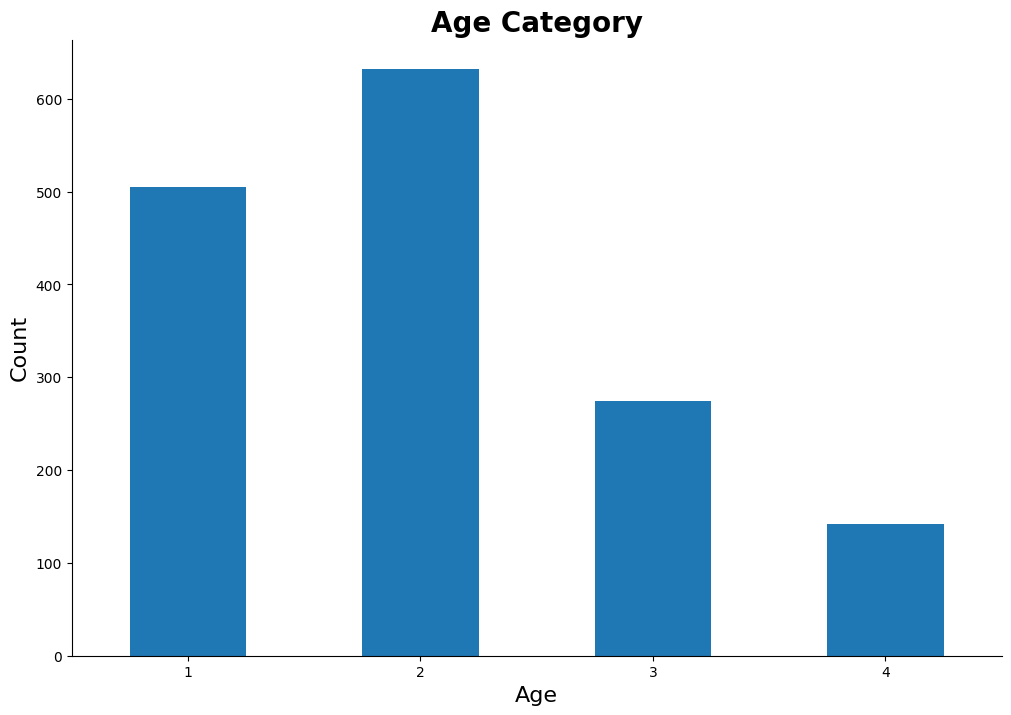

In [10]:
ax = X_train['age_cat'].value_counts().sort_index().plot.bar(figsize=(12,8))
ax.set_ylabel("Count", fontsize = 16)
ax.set_xlabel("Age", fontsize = 16)
ax.set_title("Age Category", fontweight='bold', fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

# Chapter 3 - Training model
This chapter involves:
1. [Performing k-fold cross validation](#k-fold-cross-validation)
2. [Evaluation of the training model](#evaluation-of-training-model)
    - Classification report
    - Confusion Matrix
    - ROC-AUC graph
    - Learning Curve

## K-fold cross validation

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Getting the folds 
skf:StratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy:list[float] = []
cv_f1_score:list[float] = []
cv_precision_score:list[float] = []
cv_recall_score:list[float] = []

for train_index, val_index in skf.split(X_train_processed, y_train_processed):
    # selecting the random feature set and label set
    X_train_fold, X_val_fold = X_train_processed[train_index], X_train_processed[val_index]
    y_train_fold, y_val_fold = y_train_processed[train_index], y_train_processed[val_index]

    knn_model_temp:KNeighborsClassifier = KNeighborsClassifier()
    knn_model_temp.fit(X_train_fold, y_train_fold)

    y_pred:np.array = knn_model_temp.predict(X_val_fold)

    accuracy:float = accuracy_score(y_val_fold, y_pred)
    f1:float = f1_score(y_val_fold, y_pred, average='weighted')
    precision:float = precision_score(y_val_fold, y_pred, average='weighted')
    recall:float = recall_score(y_val_fold, y_pred, average='weighted')

    cv_accuracy.append(accuracy)
    cv_precision_score.append(precision)
    cv_f1_score.append(f1)
    cv_recall_score.append(recall)

print(f'Cross-Validation Accuracy Scores:\n{cv_accuracy}')
print(f'Average Accuracy: {sum(cv_accuracy) / len(cv_accuracy)}\n')

print(f'Cross-Validation Precision Scores:\n{list(map(float,cv_precision_score))}')
print(f'Average Precision: {sum(cv_precision_score) / len(cv_precision_score)}\n')

print(f'Cross-Validation Recall Scores:\n{list(map(float,cv_recall_score))}')
print(f'Average Recall: {sum(cv_recall_score) / len(cv_recall_score)}\n')

print(f'Cross-Validation F1 Scores:\n{list(map(float, cv_f1_score))}')
print(f'Average F1: {sum(cv_f1_score) / len(cv_f1_score)}')

Cross-Validation Accuracy Scores:
[0.9839228295819936, 0.9871382636655949, 0.9903536977491961, 0.9935483870967742, 0.9806451612903225]
Average Accuracy: 0.9871216678767762

Cross-Validation Precision Scores:
[0.9838980209559758, 0.9872878187392506, 0.9906863288612929, 0.9935483870967742, 0.9819499818774917]
Average Precision: 0.9874741075061572

Cross-Validation Recall Scores:
[0.9839228295819936, 0.9871382636655949, 0.9903536977491961, 0.9935483870967742, 0.9806451612903225]
Average Recall: 0.9871216678767762

Cross-Validation F1 Scores:
[0.9838693545172303, 0.9871400029132399, 0.9903546759767846, 0.9935483870967742, 0.9806371235666059]
Average F1: 0.987109908814127


## Evaluation of Training Model

In [12]:
final_knn_model:KNeighborsClassifier = KNeighborsClassifier()
final_knn_model.fit(X_train_processed, y_train_processed)
y_train_pred:np.array = final_knn_model.predict(X_train_processed)

accuracy:float = accuracy_score(y_train_processed, y_train_pred)
f1:float = f1_score(y_train_processed, y_train_pred, average='weighted')
precision:float = precision_score(y_train_processed, y_train_pred, average='weighted')
recall:float = recall_score(y_train_processed, y_train_pred, average='weighted')

In [13]:
print("Metrics after training on the entire training set:")
print(f'Accuracy: {accuracy}')
print(f'F1: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Metrics after training on the entire training set:
Accuracy: 0.9961365099806826
F1: 0.9961367210034928
Precision: 0.9961429103417135
Recall: 0.9961365099806826


### Classification report

In [14]:
from sklearn.metrics import classification_report
# Classification report for the training set
report = classification_report(y_train_processed, y_train_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       1.00      0.99      0.99       439
      medium       0.99      1.00      0.99       417
        high       1.00      1.00      1.00       697

    accuracy                           1.00      1553
   macro avg       1.00      1.00      1.00      1553
weighted avg       1.00      1.00      1.00      1553



### Confusion Matrix

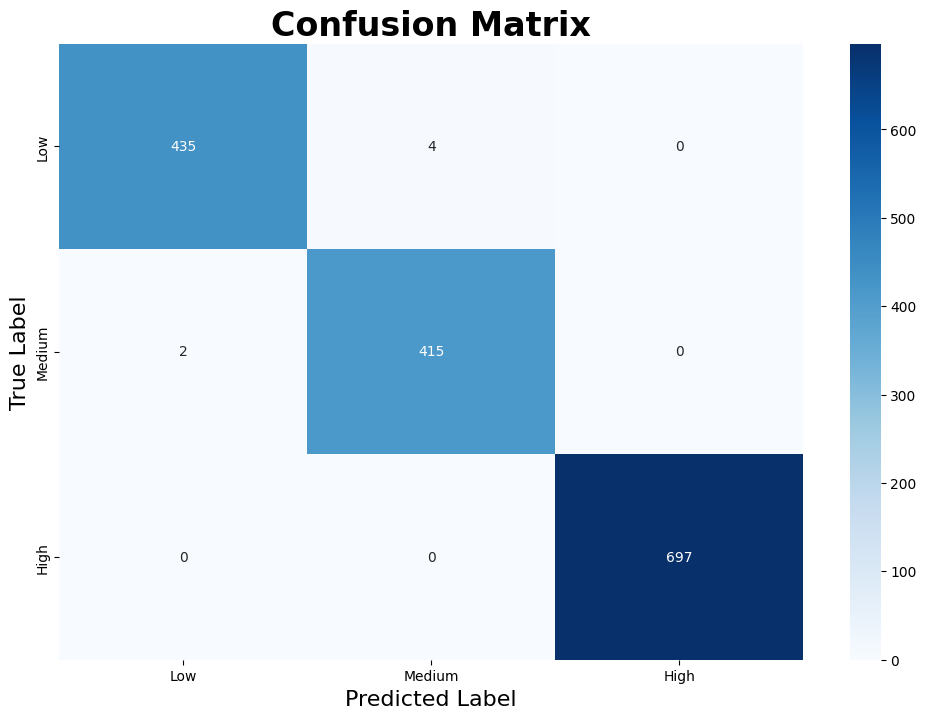

In [15]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_processed, y_train_pred, labels=[0, 1, 2])
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted Label', fontsize= 16)
plt.ylabel('True Label', fontsize= 16)
plt.title('Confusion Matrix', fontsize= 24, fontweight= 'bold')
plt.show()

### ROC-AUC Curve

AUC = 0.9998
AUC = 0.9997
AUC = 1.0000


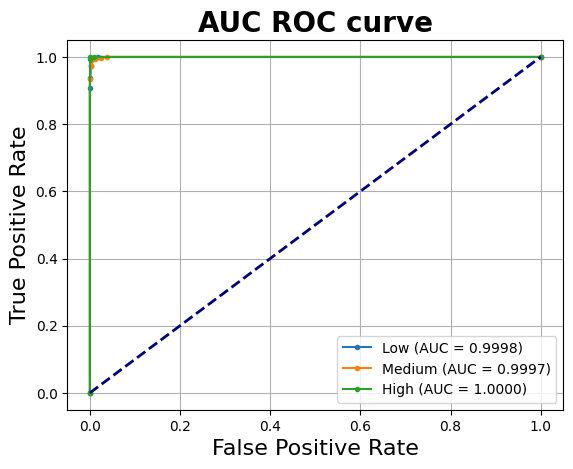

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = cross_val_predict(final_knn_model, X_train_processed, y_train_processed, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_train_processed == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_train_processed == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC curve', fontsize=20, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize =16)

plt.legend(loc ='lower right')
plt.grid(True)
plt.show()

### Learning Curve

Text(0.5, 1.0, 'Training Learning Curve')

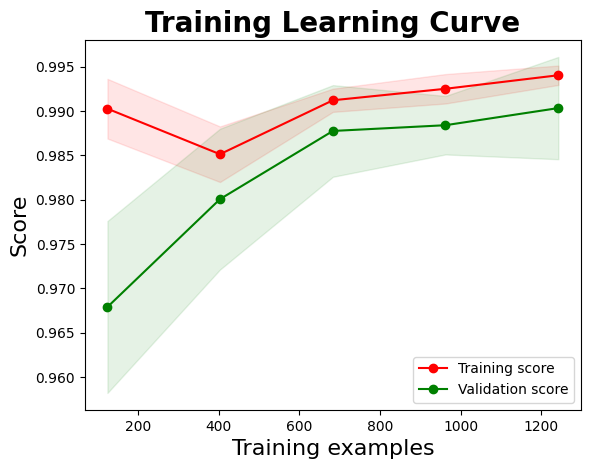

In [18]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(final_knn_model, X_train_processed, y_train_processed, cv=5, scoring='f1_weighted')

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
plt.xlabel('Training examples', fontsize = 16)
plt.ylabel('Score', fontsize = 16)
plt.legend(loc='best')
plt.title('Training Learning Curve', fontsize = 20,fontweight='bold' )

# Chapter 4 - Testing model
This chapter involves:
1. [Testing model on test set](#predicting-on-test-set)
2. [Evaluation of the model on test set](#evaluation-of-test-model)
    - Classification Report
    - Confusion Matrix
    - ROC-AUC graph

## Predicting on Test Set

In [19]:
discretise_age(X_test)

X_test_processed , y_test_processed = transform_data(X_test, y_test, lb_gender, lb_family, lb_junk_food, lb_smoking, lb_discipline, one_encoder, ordinal_encoder, label_ordinal_encoder)

y_test_pred:np.array = final_knn_model.predict(X_test_processed)

test_accuracy:float = accuracy_score(y_test_processed, y_test_pred)
test_f1:float = f1_score(y_test_processed, y_test_pred, average='weighted')
test_precision:float = precision_score(y_test_processed, y_test_pred, average='weighted')
test_recall:float = recall_score(y_test_processed, y_test_pred, average='weighted')

## Evaluation of Test Model

In [20]:
print("Testing Metrics:")
print(f'Accuracy: {test_accuracy}')
print(f'Precision: {test_precision}')
print(f'Recall: {test_recall}')
print(f'F1: {test_f1}')

Testing Metrics:
Accuracy: 0.987146529562982
Precision: 0.987736138298625
Recall: 0.987146529562982
F1: 0.9871479329334849


### Classification report

In [21]:
from sklearn.metrics import classification_report
# Classification report for the test set
report:classification_report = classification_report(y_test_processed, y_test_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       1.00      0.95      0.98       110
      medium       0.95      1.00      0.98       104
        high       1.00      1.00      1.00       175

    accuracy                           0.99       389
   macro avg       0.98      0.98      0.98       389
weighted avg       0.99      0.99      0.99       389



### Confusion Matrix

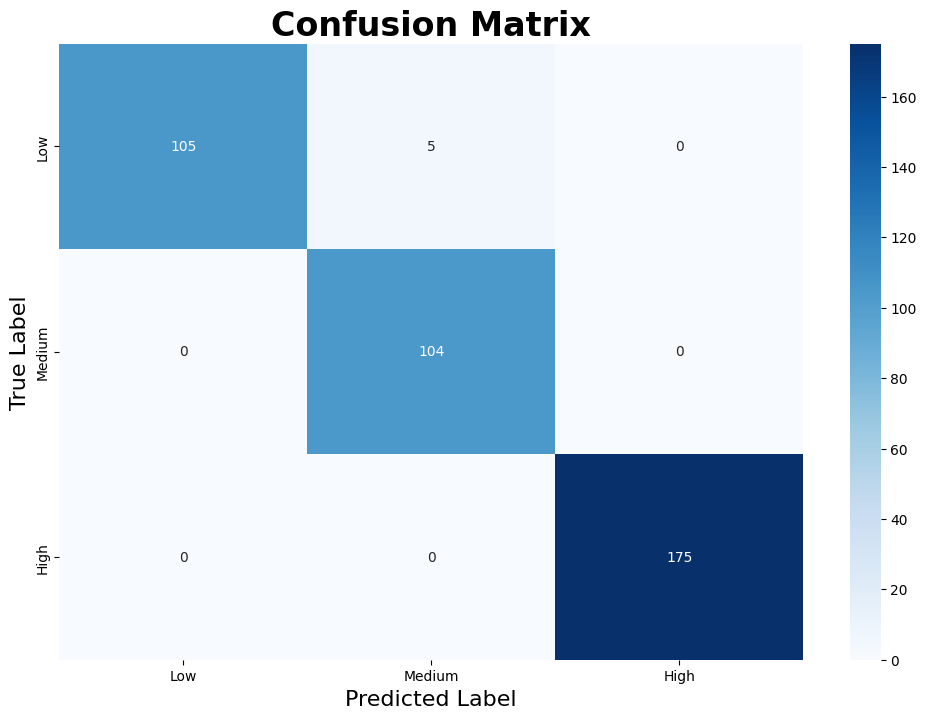

In [22]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_processed, y_test_pred, labels=[0.0, 1.0, 2.0])
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted Label', fontsize= 16)
plt.ylabel('True Label', fontsize= 16)
plt.title('Confusion Matrix', fontsize= 24, fontweight= 'bold')
plt.show()

### ROC-AUC Curve

AUC = 0.9992
AUC = 0.9987
AUC = 1.0000


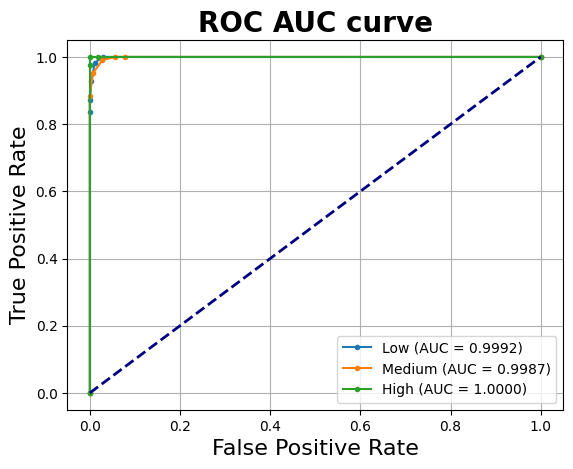

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = cross_val_predict(final_knn_model, X_test_processed, y_test_processed, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_test_processed == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_test_processed == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC curve', fontsize=20, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize =16)

plt.legend(loc ='lower right')
plt.grid(True)
plt.show()

# Chapter 5 - Fine Tuning
This chapter involves:
1. [Fine Tune with GridSearch](#gridsearch)
    - `n_neighbors`
    - `metric`
        1. `euclidean`
        2. `manhattan`
        3. `minkowski`
2. [Evaluation of the fine-tuned model](#evaluation-of-fine-tuned-model)
    - Classification Report
    - Confusion Matrix
    - ROC-AUC graph

## GridSearch

In [25]:
from sklearn.model_selection import GridSearchCV
param_grid:dict[str, typing.Union[np.array, list[str]]] = {
    'n_neighbors': range(1,21),
    'metric':['euclidean', 'manhattan', 'minkowski']
}

knn:KNeighborsClassifier = KNeighborsClassifier()
grid_search:GridSearchCV = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_processed, y_train_processed)

best_knn:KNeighborsClassifier = grid_search.best_estimator_
print(best_knn)

KNeighborsClassifier(metric='euclidean', n_neighbors=4)


In [26]:
tuned_pred:np.array = best_knn.predict(X_test_processed)

tuned_accuracy:float = accuracy_score(y_test_processed, tuned_pred)
tuned_f1:float = f1_score(y_test_processed, tuned_pred, average='weighted')
tuned_precision:float = precision_score(y_test_processed, tuned_pred, average='weighted')
tuned_recall:float = recall_score(y_test_processed, tuned_pred, average='weighted')

In [27]:
print("Tuned Metrics:")
print(f'Accuracy: {tuned_accuracy}')
print(f'Precision: {tuned_precision}')
print(f'Recall: {tuned_recall}')
print(f'F1: {tuned_f1}')

Tuned Metrics:
Accuracy: 0.987146529562982
Precision: 0.9873872262575624
Recall: 0.987146529562982
F1: 0.9871870533035656


## Evaluation of Fine Tuned Model

### Classification Report

In [28]:
# Classification report for the test set
report:classification_report = classification_report(y_test_processed, tuned_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       0.99      0.97      0.98       110
      medium       0.96      0.99      0.98       104
        high       1.00      0.99      1.00       175

    accuracy                           0.99       389
   macro avg       0.98      0.99      0.99       389
weighted avg       0.99      0.99      0.99       389



### Confusion Matrix

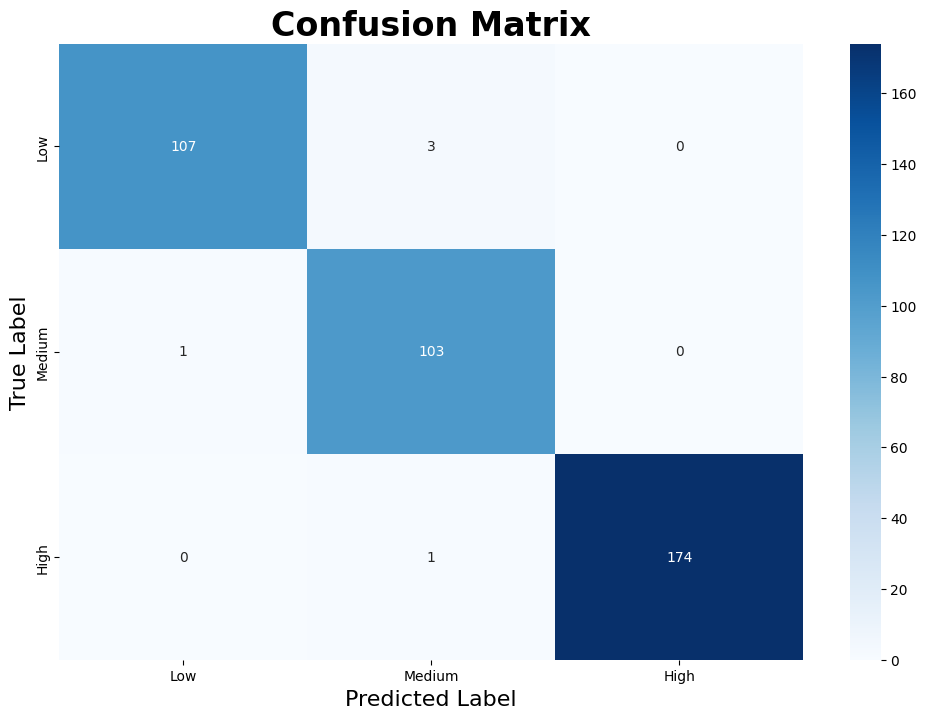

In [29]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_processed, tuned_pred, labels=[0.0, 1.0, 2.0])
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted Label', fontsize= 16)
plt.ylabel('True Label', fontsize= 16)
plt.title('Confusion Matrix', fontsize= 24, fontweight= 'bold')
plt.show()

### AUC-ROC

AUC = 0.9902
AUC = 0.9952
AUC = 1.0000


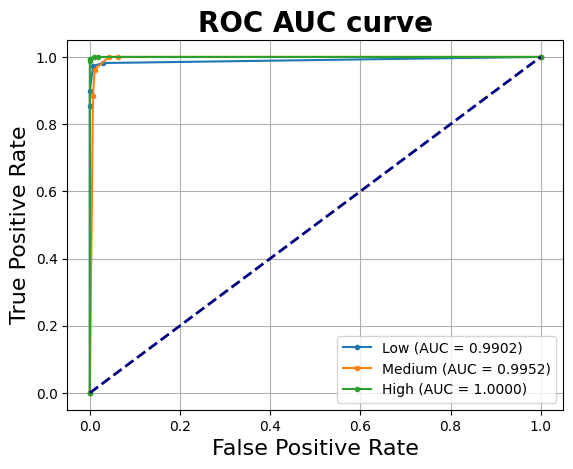

In [31]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = cross_val_predict(best_knn, X_test_processed, y_test_processed, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_test_processed == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_test_processed == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC curve', fontsize=20, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize =16)

plt.legend(loc ='lower right')
plt.grid(True)
plt.show()